# Content-based Filtering

In [ ]:
%pip install pandas -q pandas

import pandas as pd

beers_df = pd.read_csv('D:/Master/FSS_25/Web_Mining/Project/beer_reviews/beers.csv')
beers_df.head()

Note: you may need to restart the kernel to use updated packages.


,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [10]:
# Select useful columns
useful_cols = ['id', 'style', 'availability', 'country', 'abv', 'retired']
beers_df = beers_df[useful_cols]

In [11]:
# Drop missing values
beers_df.dropna(subset=['style', 'availability', 'country', 'abv'], inplace=True)

In [12]:
# Filter out abnormal abv values (less than or equal to 0, or greater than 20)
beers_df = beers_df[(beers_df['abv'] > 0) & (beers_df['abv'] < 20)]

In [13]:
# Drop duplicate beer IDs (keep the first one)
beers_df.drop_duplicates(subset='id', inplace=True)

In [14]:
# Force data type conversions
beers_df['abv'] = beers_df['abv'].astype(float)
beers_df['retired'] = beers_df['retired'].astype(str)

In [15]:
# Reset index
beers_df.reset_index(drop=True, inplace=True)

In [19]:
# Stratified sampling: sample up to 50 beers per style
beers_df = (
    beers_df.groupby('style', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 50), random_state=42))
    .reset_index(drop=True)
)

print("Stratified sampling completed! {} records retained.".format(len(beers_df)))
beers_df.head()

Stratified sampling completed! 5535 records retained.


C:\Users\97\AppData\Local\Temp\ipykernel_4928\3672703020.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), 50), random_state=42))


,id,style,availability,country,abv,retired
0,8704,American Adjunct Lager,Year-round,CO,4.0,f
1,50819,American Adjunct Lager,Year-round,CA,5.0,f
2,3474,American Adjunct Lager,Year-round,US,5.9,f
3,26195,American Adjunct Lager,Year-round,SV,3.7,f
4,36940,American Adjunct Lager,Year-round,US,5.2,f


In [25]:
beers_df.to_csv('D:/Master/FSS_25/Web_Mining/Project/cleaned_beers.csv', index=False)

# Construct feature vectors for each beer

In [20]:
%pip install -q scikit-learn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np

# Define columns
categorical_cols = ['style', 'availability', 'country', 'retired']
numerical_cols = ['abv']

# One-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = ohe.fit_transform(beers_df[categorical_cols])

# Normalize numerical features
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(beers_df[numerical_cols])

# Combine into final feature matrix
beer_vectors = np.hstack((numerical_scaled, categorical_encoded))

# Store beer ID for later reference
beer_ids = beers_df['id'].values

Note: you may need to restart the kernel to use updated packages.


# Define the recommendation function

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Create mapping from beer_id to its feature vector
beer_id_to_vector = dict(zip(beer_ids, beer_vectors))

# Recommendation function: return top-N similar beers
def recommend_similar_beers(beer_id, top_n=5):
    if beer_id not in beer_id_to_vector:
        return f"Beer ID {beer_id} not found."

    target_vector = beer_id_to_vector[beer_id].reshape(1, -1)
    similarities = cosine_similarity(target_vector, beer_vectors)[0]

    sim_df = pd.DataFrame({
        'beer_id': beer_ids,
        'similarity': similarities
    })

    sim_df = sim_df[sim_df['beer_id'] != beer_id]
    top_recs = sim_df.sort_values(by='similarity', ascending=False).head(top_n)

    return beers_df[beers_df['id'].isin(top_recs['beer_id'].values)].merge(
    top_recs.rename(columns={'beer_id': 'id'}), on='id'
).sort_values(by='similarity', ascending=False)

# Try a recommendation

In [24]:
# Pick a beer to test
sample_beer_id = beers_df.iloc[0]['id']
print("Recommendations for Beer ID:", sample_beer_id)

# Get similar beers
recommend_similar_beers(sample_beer_id, top_n=10)

Recommendations for Beer ID: 8704


,id,style,availability,country,abv,retired,similarity
1,36940,American Adjunct Lager,Year-round,US,5.2,f,0.753076
9,137557,American Adjunct Lager,Year-round,CA,5.5,f,0.753073
7,62084,American Adjunct Lager,Year-round,US,5.5,f,0.753073
0,50819,American Adjunct Lager,Year-round,CA,5.0,f,0.753054
2,30922,American Adjunct Lager,Year-round,CA,5.0,f,0.753054
6,2549,American Adjunct Lager,Year-round,CA,5.0,f,0.753054
8,6239,American Adjunct Lager,Year-round,US,5.0,f,0.753054
5,261312,American Adjunct Lager,Year-round,CU,4.9,f,0.753035
3,90021,American Adjunct Lager,Year-round,CA,4.9,f,0.753035
4,1849,American Adjunct Lager,Year-round,CA,4.9,f,0.753035


# Top-N Style Consistency Scoring Function

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def top_n_style_consistency(beer_vectors, beers_df, top_n=5):
    # Compute similarity matrix
    similarity_matrix = cosine_similarity(beer_vectors)
    np.fill_diagonal(similarity_matrix, -1)  

    # Count consistency
    consistent_count = 0
    total_count = 0

    for i, row in beers_df.iterrows():
        top_indices = similarity_matrix[i].argsort()[-top_n:] 
        ref_style = row['style']
        top_styles = beers_df.iloc[top_indices]['style']
        consistent_count += sum(top_styles == ref_style)
        total_count += top_n

    consistency = consistent_count / total_count
    return consistency

score = top_n_style_consistency(beer_vectors, beers_df, top_n=10)
print(f" Top-10 Style Consistency Score: {score:.2%}")

 Top-10 Style Consistency Score: 55.59%


# Beer Style Consistency Analysis by Style with Top-N Similarity

Note: you may need to restart the kernel to use updated packages.


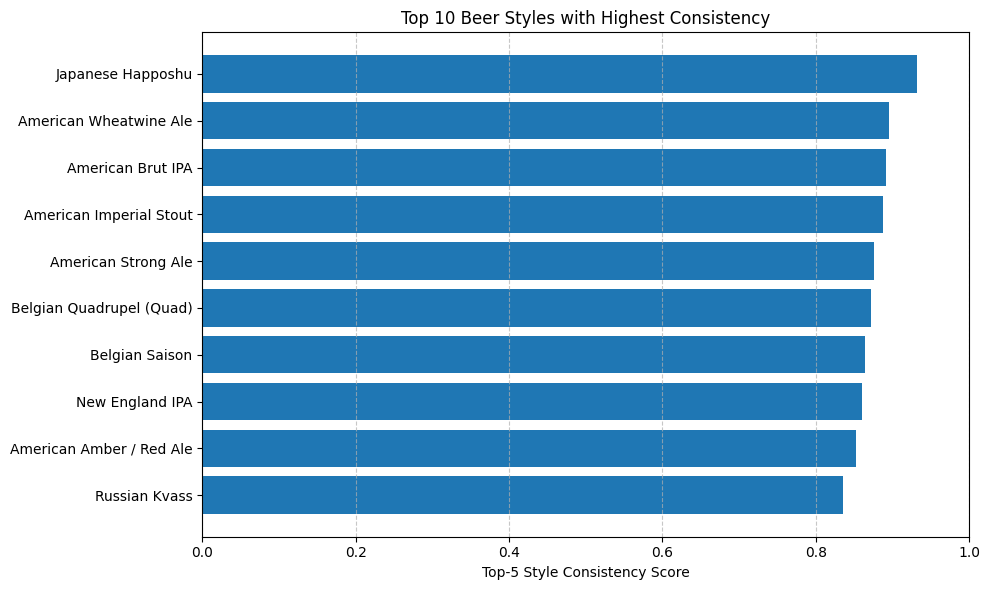

In [ ]:
%pip install matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


# Calculate top-N consistency score for each style
def style_wise_consistency(beer_vectors, beers_df, top_n=5):
    similarity_matrix = cosine_similarity(beer_vectors)
    np.fill_diagonal(similarity_matrix, -1)

    style_scores = {}

    for style in beers_df['style'].unique():
        style_indices = beers_df[beers_df['style'] == style].index
        if len(style_indices) < 2:
            continue  

        total, correct = 0, 0
        for idx in style_indices:
            top_indices = similarity_matrix[idx].argsort()[-top_n:]
            recommended_styles = beers_df.iloc[top_indices]['style']
            correct += sum(recommended_styles == style)
            total += top_n

        style_scores[style] = correct / total if total > 0 else 0.0

    return style_scores


style_consistency_scores = style_wise_consistency(beer_vectors, beers_df, top_n=5)

# Get the top 10 beer styles with highest consistency scores
top_styles_10 = dict(sorted(style_consistency_scores.items(), key=lambda item: item[1], reverse=True)[:10])


plt.figure(figsize=(10, 6))
plt.barh(list(top_styles_10.keys())[::-1], list(top_styles_10.values())[::-1])
plt.xlabel("Top-5 Style Consistency Score")
plt.title("Top 10 Beer Styles with Highest Consistency")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()